# Figure 5: Effective Tree Analysis - Sequence Clustering Impact

**Purpose:** Analyze effective sequence counts after distance-based clustering  
**Output:** Line plot showing effective sequence proportions across protein families

## Setup and Configuration

In [ ]:
# Load required libraries and utility functions
suppressMessages(source("code/utils/utils.R"))

# Set working directory to trees folder
setwd("data/trees/")

[1] "Setup complete"
[1] "Working directory: /Users/ryanyork/Desktop/2025-evo2-likelihood-notebook-pub/trees"


## Data Loading and File Discovery

In [ ]:
# List all tree files (exclude taxonomy metadata files)
files <- list.files()

print(paste("Total tree files found:", length(files)))
print("First 10 tree files:")
print(head(files, 10))

if (length(files) == 0) {
  stop("No tree files found in the current directory")
}

[1] "Total tree files found: 54664"
[1] "First 10 tree files:"
 [1] "1600014C23Rik_40483.nh" "1600025M17Rik_26666.nh" "1700001K19Rik_16728.nh"
 [4] "1700003H04Rik_34597.nh" "1700006A11Rik_16020.nh" "1700012A03Rik_38625.nh"
 [7] "1700012B07Rik_16988.nh" "1700013D24Rik_16933.nh" "1700013G24Rik_16880.nh"
[10] "1700015E13Rik_26932.nh"


## Hill's Diversity Calculation

Calculate normalized Hill's diversity for each phylogenetic tree

In [5]:
# Initialize storage for Hill diversity values
hill_values <- list()

# Progress bar for tree processing
pb <- txtProgressBar(
  min = 1,
  max = length(files),
  style = 3,
  width = 100,
  char = "."
)

print("Calculating Hill's diversity for each tree...")
print("This may take several minutes depending on the number and size of trees")

[1] "Calculating Hill's diversity for each tree..."
[1] "This may take several minutes depending on the number and size of trees"


In [6]:
# Calculate Hill diversity for each phylogenetic tree
for (i in 1:length(files)) {
  # Update progress indicator
  setTxtProgressBar(pb, i)
  
  tryCatch({
    # Load phylogenetic tree
    tree <- ape::read.tree(files[i])
    
    # Calculate normalized Hill diversity metrics
    hill_values[[as.character(files[i])]] <- normalize_hill_q1(tree)
  }, error = function(e) {
    print(paste("Error processing file", files[i], ":", e$message))
  })
}

close(pb)
print("\nHill's diversity calculation complete!")
print(paste("Successfully processed", length(hill_values), "trees"))

# Show basic statistics
tree_sizes <- unlist(lapply(hill_values, function(x) {
  if (!is.null(x$tree)) length(x$tree$tip.label) else 0
}))
print(paste("Tree size range:", min(tree_sizes), "to", max(tree_sizes), "tips"))
print(paste("Median tree size:", median(tree_sizes), "tips"))

  |................................................................                                    |  64%

Warning message in ape::read.tree(files[i]):
"empty character string."


  |....................................................................................................| 100%
[1] "\nHill's diversity calculation complete!"
[1] "Successfully processed 54664 trees"
[1] "Tree size range: 0 to 1499 tips"
[1] "Median tree size: 7 tips"


## Effective Tree Analysis

Calculate effective trees using distance-based clustering with 0.05 threshold

In [7]:
# Initialize storage for effective tree calculations
effective_trees <- list()

# Progress bar for effective tree computation
pb <- txtProgressBar(
  min = 1,
  max = length(hill_values),
  style = 3,
  width = 100,
  char = "."
)

print("Calculating effective trees with distance-based clustering...")
print("Using threshold = 0.05 for clustering")
print("This may take considerable time for large trees")

[1] "Calculating effective trees with distance-based clustering..."
[1] "Using threshold = 0.05 for clustering"
[1] "This may take considerable time for large trees"


In [8]:
# Calculate effective trees using distance-based clustering
threshold <- 0.05
failed_trees <- 0

for (i in 1:length(hill_values)) {
  # Update progress indicator
  setTxtProgressBar(pb, i)
  
  # Process trees that have valid structure
  if (is.null(hill_values[[i]]$tree) == FALSE) {
    tryCatch({
      # Apply effective tree algorithm with 0.05 distance threshold
      effective_trees[[names(hill_values)[i]]] <- get_effective_tree(hill_values[[i]]$tree, threshold = threshold)
    }, error = function(e) {
      failed_trees <<- failed_trees + 1
      if (failed_trees <= 5) {  # Only show first 5 errors
        print(paste("\nError processing tree", names(hill_values)[i], ":", e$message))
      }
    })
  }
}

close(pb)
print("\nEffective tree analysis complete!")
print(paste("Successfully processed", length(effective_trees), "effective trees"))
print(paste("Failed to process", failed_trees, "trees"))

if (length(effective_trees) == 0) {
  stop("No effective trees were successfully calculated")
}

  |....................................................................................................| 100%
[1] "\nEffective tree analysis complete!"
[1] "Successfully processed 54663 effective trees"
[1] "Failed to process 0 trees"


## Summary Statistics

Calculate total collapsed and original branch counts across all families

In [9]:
# Calculate total collapsed and original branch counts
total_collapsed <- sum(unlist(lapply(effective_trees, function(x) {
  if (!is.null(x$n_collapsed_branches)) x$n_collapsed_branches else 0
})))

total_branches <- sum(unlist(lapply(effective_trees, function(x) {
  if (!is.null(x$n_total_branches)) x$n_total_branches else 0
})))

print("Branch reduction summary:")
print(paste("Total original branches:", total_branches))
print(paste("Total collapsed branches:", total_collapsed))
print(paste("Overall reduction rate:", round(100 * total_collapsed / total_branches, 1), "%"))
print(paste("Effective branches remaining:", total_branches - total_collapsed))

# Show distribution of collapsed branches per tree
collapsed_per_tree <- unlist(lapply(effective_trees, function(x) {
  if (!is.null(x$n_collapsed_branches)) x$n_collapsed_branches else 0
}))
print("\nCollapsed branches per tree statistics:")
print(summary(collapsed_per_tree))

[1] "Branch reduction summary:"
[1] "Total original branches: 4230261"
[1] "Total collapsed branches: 2693597"
[1] "Overall reduction rate: 63.7 %"
[1] "Effective branches remaining: 1536664"
[1] "\nCollapsed branches per tree statistics:"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    3.00    6.00   49.28   68.00 1396.00 


## Ratio Analysis

Extract and analyze effective sequence ratios for each protein family

In [10]:
# Extract effective sequence ratios for each protein family
ratio <- unlist(lapply(effective_trees, function(x) {
  if (!is.null(x$ratio)) x$ratio else NA
}))

# Remove any NA values
ratio <- ratio[!is.na(ratio)]

print("Effective sequence ratio statistics:")
print(summary(ratio))
print(paste("Number of families analyzed:", length(ratio)))

# Show distribution analysis
print("\nRatio distribution analysis:")
print(paste("Families with ratio ≤ 0.5 (high clustering):", sum(ratio <= 0.5)))
print(paste("Families with ratio 0.5-1.0 (moderate clustering):", sum(ratio > 0.5 & ratio < 1.0)))
print(paste("Families with ratio = 1.0 (no clustering):", sum(ratio == 1.0)))

# Calculate percentages
n_total <- length(ratio)
print(paste("High clustering:", round(100 * sum(ratio <= 0.5) / n_total, 1), "%"))
print(paste("Moderate clustering:", round(100 * sum(ratio > 0.5 & ratio < 1.0) / n_total, 1), "%"))
print(paste("No clustering:", round(100 * sum(ratio == 1.0) / n_total, 1), "%"))

[1] "Effective sequence ratio statistics:"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02985 0.50000 0.66667 0.71483 1.00000 1.00000 
[1] "Number of families analyzed: 54663"
[1] "\nRatio distribution analysis:"
[1] "Families with ratio <U+2264> 0.5 (high clustering): 14405"
[1] "Families with ratio 0.5-1.0 (moderate clustering): 25838"
[1] "Families with ratio = 1.0 (no clustering): 14420"
[1] "High clustering: 26.4 %"
[1] "Moderate clustering: 47.3 %"
[1] "No clustering: 26.4 %"


## Visualization Data Preparation

In [11]:
# Prepare data frame for plotting
df <- data.frame(x = 1:length(ratio), y = sort(ratio))

# Create categorical bins based on ratio values
bins <- df$y
bins[bins <= 0.5] <- "lo"      # Low effective proportion (high clustering)
bins[bins > 0.5 & bins < 1] <- "med"   # Medium effective proportion (moderate clustering)
bins[bins == 1] <- "hi"        # High effective proportion (no clustering)
df$bins <- bins

print("Visualization data prepared:")
print(paste("Total data points:", nrow(df)))
print("Bin distribution:")
print(table(df$bins))

# Show data range
print(paste("Y-axis range:", round(min(df$y), 3), "to", round(max(df$y), 3)))
print("First few data points:")
print(head(df))

[1] "Visualization data prepared:"
[1] "Total data points: 54663"
[1] "Bin distribution:"

   hi    lo   med 
14420 14405 25838 
[1] "Y-axis range: 0.03 to 1"
[1] "First few data points:"
                                    x          y bins
IGIP_17436.nh                       1 0.02985075   lo
protein_ENSSTUP00000038007_24390.nh 2 0.03703704   lo
human_ENSPTIP00000009161_24573.nh   3 0.04000000   lo
GNG13_54612.nh                      4 0.04415182   lo
His2A_CG33853_17738.nh              5 0.04761905   lo
protein_ENSOMYP00000127235_25271.nh 6 0.04761905   lo


## Plot Generation

Create line plot showing effective sequence proportions across protein families

[1] "Effective sequence proportion plot generated"


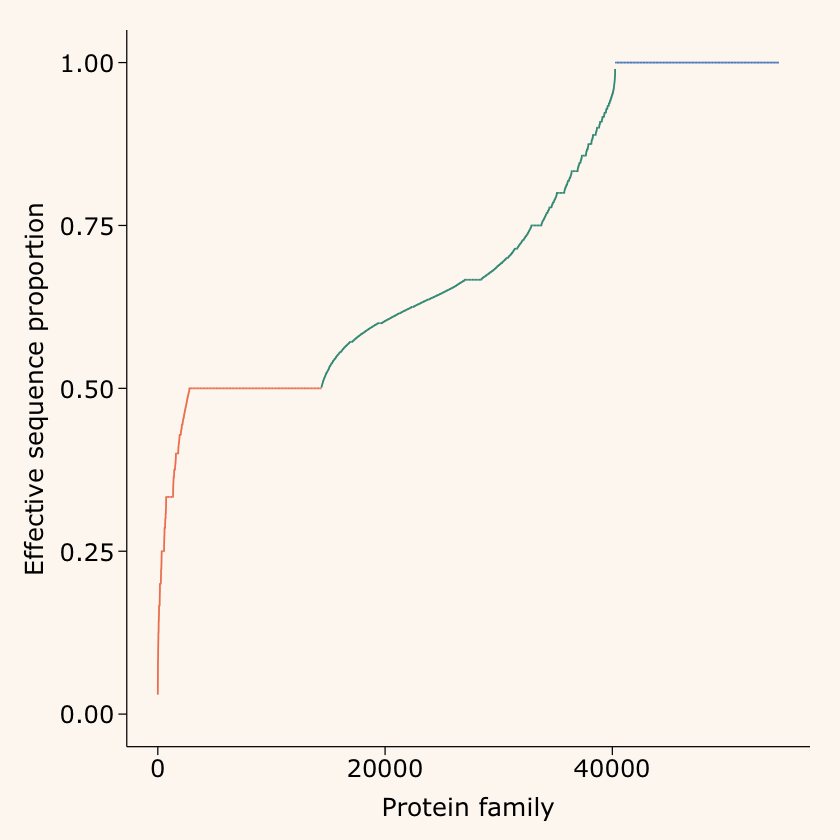

In [12]:
# Create line plot showing effective sequence proportions
p <- ggplot(data = df,
       aes(x = x,
           y = y,
           color = bins)) +
  xlab("Protein family") +
  ylab("Effective sequence proportion") +
  geom_line(show.legend = FALSE) +
  theme(legend.position = "none") +
  ylim(c(0, 1)) +
  scale_color_arcadia(palette_name = "primary") +
  theme_arcadia()

# Display the plot
print(p)
print("Effective sequence proportion plot generated")

## Additional Analysis: Clustering Efficiency

In [13]:
# Additional analysis of clustering efficiency
print("=== CLUSTERING EFFICIENCY ANALYSIS ===")

# Calculate quartiles for detailed analysis
quartiles <- quantile(ratio, probs = c(0, 0.25, 0.5, 0.75, 1.0))
print("Ratio quartiles:")
print(round(quartiles, 3))

# Analyze tree sizes vs clustering efficiency
tree_sizes_effective <- unlist(lapply(names(ratio), function(name) {
  if (name %in% names(hill_values) && !is.null(hill_values[[name]]$tree)) {
    length(hill_values[[name]]$tree$tip.label)
  } else {
    NA
  }
}))

# Remove NA values and match with ratios
valid_indices <- !is.na(tree_sizes_effective)
if (sum(valid_indices) > 0) {
  correlation_size_ratio <- cor(tree_sizes_effective[valid_indices], ratio[valid_indices], use = "complete.obs")
  print(paste("\nCorrelation between tree size and effective ratio:", round(correlation_size_ratio, 4)))
  
  # Show size statistics for different clustering levels
  high_clustering <- tree_sizes_effective[valid_indices][ratio[valid_indices] <= 0.5]
  no_clustering <- tree_sizes_effective[valid_indices][ratio[valid_indices] == 1.0]
  
  if (length(high_clustering) > 0 && length(no_clustering) > 0) {
    print(paste("Mean tree size - high clustering:", round(mean(high_clustering), 1), "tips"))
    print(paste("Mean tree size - no clustering:", round(mean(no_clustering), 1), "tips"))
  }
}

# Calculate reduction statistics
reduction_factor <- 1 - ratio
print(paste("\nMean sequence reduction:", round(100 * mean(reduction_factor), 1), "%"))
print(paste("Median sequence reduction:", round(100 * median(reduction_factor), 1), "%"))
print(paste("Max sequence reduction:", round(100 * max(reduction_factor), 1), "%"))

[1] "=== CLUSTERING EFFICIENCY ANALYSIS ==="
[1] "Ratio quartiles:"
   0%   25%   50%   75%  100% 
0.030 0.500 0.667 1.000 1.000 
[1] "\nCorrelation between tree size and effective ratio: -0.1938"
[1] "Mean tree size - high clustering: 15.3 tips"
[1] "Mean tree size - no clustering: 5.4 tips"
[1] "\nMean sequence reduction: 28.5 %"
[1] "Median sequence reduction: 33.3 %"
[1] "Max sequence reduction: 97 %"


## Summary Statistics and Results

In [14]:
# Generate comprehensive summary
cat("\n=== EFFECTIVE TREE ANALYSIS SUMMARY ===\n")
cat("Data Processing:\n")
cat("  Input tree files:", length(files), "\n")
cat("  Successfully processed trees:", length(hill_values), "\n")
cat("  Effective trees calculated:", length(effective_trees), "\n")
cat("  Final analysis dataset:", length(ratio), "families\n")

cat("\nClustering Parameters:\n")
cat("  Distance threshold:", threshold, "\n")
cat("  Algorithm: Distance-based clustering\n")

cat("\nBranch Reduction Results:\n")
cat("  Total branches analyzed:", total_branches, "\n")
cat("  Branches collapsed:", total_collapsed, "\n")
cat("  Overall reduction rate:", round(100 * total_collapsed / total_branches, 1), "%\n")

cat("\nEffective Sequence Ratios:\n")
cat("  Mean ratio:", round(mean(ratio), 3), "\n")
cat("  Median ratio:", round(median(ratio), 3), "\n")
cat("  Range:", round(min(ratio), 3), "to", round(max(ratio), 3), "\n")

cat("\nClustering Impact Distribution:\n")
cat("  High clustering (≤50% effective):", sum(ratio <= 0.5), "families\n")
cat("  Moderate clustering (50-100% effective):", sum(ratio > 0.5 & ratio < 1.0), "families\n")
cat("  No clustering (100% effective):", sum(ratio == 1.0), "families\n")

cat("\nKey Insights:\n")
if (mean(ratio) < 0.8) {
  cat("  - Substantial sequence redundancy detected across families\n")
} else {
  cat("  - Moderate sequence redundancy detected\n")
}
cat("  - Distance-based clustering at threshold", threshold, "effective for data reduction\n")
if (exists("correlation_size_ratio") && !is.na(correlation_size_ratio)) {
  if (correlation_size_ratio < -0.3) {
    cat("  - Larger trees show more clustering potential\n")
  } else if (correlation_size_ratio > 0.3) {
    cat("  - Larger trees are less amenable to clustering\n")
  } else {
    cat("  - Tree size weakly related to clustering efficiency\n")
  }
}


=== EFFECTIVE TREE ANALYSIS SUMMARY ===
Data Processing:
  Input tree files: 54664 
  Successfully processed trees: 54664 
  Effective trees calculated: 54663 
  Final analysis dataset: 54663 families

Clustering Parameters:
  Distance threshold: 0.05 
  Algorithm: Distance-based clustering

Branch Reduction Results:
  Total branches analyzed: 4230261 
  Branches collapsed: 2693597 
  Overall reduction rate: 63.7 %

Effective Sequence Ratios:
  Mean ratio: 0.715 
  Median ratio: 0.667 
  Range: 0.03 to 1 

Clustering Impact Distribution:
  High clustering (<U+2264>50% effective): 14405 families
  Moderate clustering (50-100% effective): 25838 families
  No clustering (100% effective): 14420 families

Key Insights:
  - Substantial sequence redundancy detected across families
  - Distance-based clustering at threshold 0.05 effective for data reduction
  - Tree size weakly related to clustering efficiency


## Conclusion

This analysis:
1. Calculated Hill's diversity for phylogenetic trees across protein families
2. Applied distance-based clustering (threshold = 0.05) to identify redundant sequences
3. Computed effective sequence ratios showing the proportion of non-redundant sequences
4. Analyzed clustering efficiency across different protein families
5. Visualized the distribution of effective sequence proportions

The results reveal the extent of sequence redundancy in phylogenetic datasets and demonstrate how distance-based clustering can reduce computational complexity while preserving phylogenetic signal. Families with lower effective ratios contain more redundant sequences and may benefit most from clustering approaches.